In [2]:
import os
import os.path as osp
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FixedLocator
# from tabulate import tabulate, SEPARATING_LINE
import json

from panda.density_profile import get_numerical_density_profile
from panda.profile_approx import profile_approx_from_array
import panda.interface

In [3]:
# Load Helvetica font from file
root = os.environ['HOME']
font_path = f"{root}/HelveticaNeue.ttc"  # Update this path
helvetica_font = fm.FontProperties(fname=font_path)

---

## Theta and Alpha comparison

In [4]:
shapes = ['droplet', 'doughnut', 'worm', 'roll', 'perforation']

In [5]:
mean_angles_alpha = []
std_angles_alpha = []
mean_angles_theta = []
std_angles_theta = []

rmse_angles_theta = []
rmse_angles_alpha = []

mean_mae_theta = []
std_mae_theta = []
mean_mae_alpha = []
std_mae_alpha = []

mean_rmse_theta = []
std_rmse_theta = []
mean_rmse_alpha = []
std_rmse_alpha = []

for shape in shapes:
    print(f'Proccessing {shape}')
    folder = f'{root}/PANDA_exp/panda_nn/calcite_decane_water_{shape}'

    # Configuration parameters of the system
    with open(osp.join(folder, 'config.json'), 'r') as f:
        config = json.load(f)

    trajectory_file = osp.join(folder, 'cal_dec_tip4p.xtc')
    topology_file = osp.join(folder, 'cal_dec_tip4p.gro')
    residue = 'DECAN'
    H = config['H']
    l = (12.003 + 11.244) / 2 / H
    phi = config['phi']
    rho_bulk = 3.0896 * 10
    interface_type = config['interface_type']
    sl = 200
    timestep = 2
    units = "ps"
    block_length = 1_000
    chunk_length = 1_000
    begin_time = 0
    time = config['nsteps'] * timestep // 1000

    axises = np.load(osp.join(folder, 'axises.npy'))
    denses = np.load(osp.join(folder, 'denses.npy'))

    # Averaging axises and denses arrays by blocks
    blocks_num = axises.shape[0] // block_length

    mean_axises = np.zeros((blocks_num, axises.shape[1]))
    mean_denses = np.zeros((blocks_num, denses.shape[1]))
    for i in range(blocks_num):
        mean_axises[i, :] = np.mean(axises[(i * block_length):((i+1) * block_length), :], axis=0)
        mean_denses[i, :] = np.mean(denses[(i * block_length):((i + 1) *block_length), :], axis=0)

    # Calculating contact angle using PANDA algorithm
    angles_theta = np.zeros(blocks_num)
    angles_alpha = np.zeros(blocks_num)
    delta_alpha = np.zeros(blocks_num)

    target_angles = np.full(blocks_num, 120)

    mae_theta = np.zeros(blocks_num)
    mae_alpha = np.zeros(blocks_num)
    rmse_theta = np.zeros(blocks_num)
    rmse_alpha = np.zeros(blocks_num)

    normalized_axises = np.zeros((blocks_num, axises.shape[1]))
    normalized_denses = np.zeros((blocks_num, denses.shape[1]))
    for i in range(blocks_num):
        axis_i, dens_i, result_theta = profile_approx_from_array(
            mean_denses[i, :],
            mean_axises[i, :],
            rho_bulk,
            l,
            phi,
            H,
            interface_type=interface_type,
            samples=10,
            extention='theta',
            display=False
        )

        _, _, result_alpha = profile_approx_from_array(
            mean_denses[i, :],
            mean_axises[i, :],
            rho_bulk,
            l,
            phi,
            H,
            interface_type=interface_type,
            samples=10,
            extention='alpha',
            display=False
        )

        normalized_axises[i, :] = axis_i
        normalized_denses[i, :] = dens_i

        angles_theta[i] = result_theta['theta']
        angles_alpha[i] = result_alpha['theta']
        delta_alpha[i] = result_alpha['delta']

        mae_theta[i] = result_theta['mae']
        mae_alpha[i] = result_alpha['mae']

        rmse_theta[i] = result_theta['rmse']
        rmse_alpha[i] = result_alpha['rmse']

    # Averagin angle for different interface
    begin_alpha = 2
    mean_angle = np.mean(np.rad2deg(angles_alpha)[begin_alpha:])
    std_angle = np.std(np.rad2deg(angles_alpha)[begin_alpha:])
    mean_angles_alpha.append(mean_angle)
    std_angles_alpha.append(std_angle)

    rmse_angles_alpha.append(np.sqrt(np.mean((np.rad2deg(angles_alpha)[begin_alpha:] - target_angles[begin_alpha:])**2)))

    mean_mae_alpha.append(np.mean(mae_alpha[begin_alpha:]))
    std_mae_alpha.append(np.std(mae_alpha[begin_alpha:]))
    mean_rmse_alpha.append(np.mean(rmse_alpha[begin_alpha:]))
    std_rmse_alpha.append(np.std(rmse_alpha[begin_alpha:]))

    begin_theta = 2
    mean_angle = np.mean(np.rad2deg(angles_theta)[begin_theta:])
    std_angle = np.std(np.rad2deg(angles_theta)[begin_theta:])
    mean_angles_theta.append(mean_angle)
    std_angles_theta.append(std_angle)

    rmse_angles_theta.append(np.sqrt(np.mean((np.rad2deg(angles_theta)[begin_theta:] - target_angles[begin_theta:])**2)))

    mean_mae_theta.append(np.mean(mae_theta[begin_theta:]))
    std_mae_theta.append(np.std(mae_theta[begin_theta:]))
    mean_rmse_theta.append(np.mean(rmse_theta[begin_theta:]))
    std_rmse_theta.append(np.std(rmse_theta[begin_theta:]))

Proccessing droplet
Proccessing doughnut
Proccessing worm
Proccessing roll
Proccessing perforation


/home/fluffymelon/PANDA/panda/interface/alpha.py:283: RuntimeWarning: invalid value encountered in sqrt
  return 0.25 * sqrt(a - b + c + d) + e - f


In [6]:
print(mean_angles_theta)
print(mean_angles_alpha)
print(std_angles_theta)
print(std_angles_alpha)

[np.float64(118.65375005409659), np.float64(134.12636154765798), np.float64(133.64392007744783), np.float64(140.7491855486016), np.float64(145.17254655022973)]
[np.float64(118.51237732271245), np.float64(116.26919530431655), np.float64(133.64392007744783), np.float64(114.40129397981907), np.float64(118.58671594190226)]
[np.float64(2.600258408588031), np.float64(2.026043884167063), np.float64(2.7942148598260474), np.float64(7.248774941051081), np.float64(2.610664512541317)]
[np.float64(2.5470656389296833), np.float64(2.014601813548895), np.float64(2.7942148598260474), np.float64(3.029236021861136), np.float64(2.5400806708928756)]


In [7]:
approx_angles_droplet = np.array([124.21047960538968, 104.74764870496907, 106.48003104296302, 103.99591378460943, 100.45961520089426, 103.68037496298888, 105.8057892633088, 106.76138060736884, 104.84224525473302, 99.24791417958694, 103.3392190746452, 103.34507740569923, 103.29221557451953, 100.80516664391995, 105.26375453735277, 102.32623437458054, 107.29619668402724, 108.74649171733341, 104.81464920557022, 103.93212940455746, 103.96225797256612, 108.8962379898947, 105.31097008011713, 109.49042891731877, 111.62081198548276, 103.26843019453626, 104.92703385522306, 107.28551363178929, 107.3990529550435, 105.40949839735799, 108.94510588341205, 100.56170395005068, 101.96487966891236, 100.87991464436877, 105.46318897011018, 106.27731974132878, 101.85172523031576, 104.91809276473893, 108.33985534901007, 106.83481249553545])
# In cartesian
# approx_angles_doughnut = np.array([114.57794613512063, 115.04155406161883, 114.28223864974684, 118.97242848363953, 117.86751716051188, 117.61501324411091, 119.37272976797323, 120.09053709746631, 115.44195252080776, 116.68916971606153, 119.4717681586727, 114.15222142442487, 119.8717846330281, 118.3822215599047, 117.97714814778975, 116.52756197958655, 113.10540613731945, 118.65521688030655, 115.56724727816163, 118.07713698535686, 110.44642444999859, 111.18141468383354, 113.9770295119334, 120.3839288745416, 120.08104565312463, 120.29378895547907, 115.11502595912047, 113.98592974691803, 116.56679606100943, 119.12468685835866, 120.22929049719208, 121.37214264900955, 122.89725348483692, 120.10706377121831, 119.5002882813243, 119.3207397511629, 117.72440797329008, 118.90022709088439, 119.53020143311308, 111.82258207584569])
# approx_angles_doughnut = np.array([103.53478056462883, 113.6498484739122, 111.09708209855958, 113.96997322717844, 111.91003416464288, 117.19783081723585, 118.04968596629972, 117.89359466756004, 110.43542022433594, 112.20165944463169, 118.02477596407152, 113.77795081441585, 115.56160285181724, 118.07820551923983, 117.04694336010438, 115.67186995241224, 115.34331074433642, 113.69672394334742, 113.69870374666489, 121.07860466706768, 112.61337972671627, 115.79766053267805, 110.68888886096032, 114.25095573786571, 114.40719830525431, 116.87883629301298, 115.51623430067184, 114.54348928796976, 114.32897203604476, 117.32011146608536, 115.80116501636537, 120.7485610376863, 114.55089653975138, 120.20652147598213, 117.68994677149244, 114.6146052569244, 113.96315542446617, 115.32336580883246, 117.43322280673918, 109.74214566861832])
approx_angles_doughnut = np.array([103.53478056462883, 113.6498484739122, 111.09708209855958, 113.96997322717844, 111.91003416464288, 117.19783081723585, 118.04968596629972, 117.89359466756004, 110.43542022433594, 112.20165944463169, 118.02477596407152, 113.77795081441585, 115.56160285181724, 118.07820551923983, 117.04694336010438, 115.67186995241224, 115.34331074433642, 113.69672394334742, 113.69870374666489, 121.07860466706768, 112.61337972671627, 115.79766053267805, 110.68888886096032, 114.25095573786571, 114.40719830525431, 116.87883629301298, 115.51623430067184, 114.54348928796976, 114.32897203604476, 117.32011146608536, 115.80116501636537, 120.7485610376863, 114.55089653975138, 120.20652147598213, 117.68994677149244, 114.6146052569244, 113.96315542446617, 115.32336580883246, 117.43322280673918, 109.74214566861832])
approx_angles_worm = np.array([[142.82033161336335, 129.5548605473017, 124.65891489404576, 126.83415402965069, 133.08041414444463, 133.23940486918835, 135.95739144077038, 132.46567401812462, 136.33319231112844, 136.51485618186823, 136.50617475724644, 131.4955665384186, 128.3746494422399, 136.57895257925605, 132.69642324204762, 134.8406121466179, 129.1181623269077, 132.32316013700043, 133.80495818063514, 136.0473880850182, 137.04549438215108, 133.49295681886628, 132.23360222165752, 134.2312387541652, 130.08798673770943, 132.16351070208609, 130.03700632285242, 127.64728998938412, 134.8562471864006, 130.1389458683858, 123.24145206028908, 126.4265581885886, 132.28625266036758, 130.2936366434158, 126.73844645384762, 129.72534933251666, 130.68258511761115, 137.48437934866334, 132.25841139305007, 128.41168069805119]])
approx_angles_roll = np.array([99.01356759288335, 110.3157089351169, 110.88334929290548, 117.78989871165079, 112.87468769079014, 115.90967427821833, 119.7034754702868, 114.38109604148298, 114.95799945177899, 115.9077142700106, 116.67023423790069, 111.32533140229766, 118.89339344841741, 120.30748957738237, 117.37632646667888, 118.17729087782371, 113.34415928956602, 115.0440732303423, 112.59664693376668, 114.3914039705677, 113.75101384834453, 120.29495564659544, 117.15730660569328, 115.36690095655419, 117.0108096289671, 115.3905966793805, 120.25937680387278, 118.1023175253866, 113.89270018396664, 119.31457056778638, 113.36599041137352, 118.59942834077194, 118.3728876601855, 122.0037960496261, 116.7511584772211, 113.16781105883649, 116.17412128717983, 111.83249997636622, 116.0468352506875, 119.7090581825286])
approx_angles_perforation = np.array([[105.49064006228274, 119.06892394921458, 123.82539071247608, 121.36797016979284, 125.9580353785649, 120.21572733734578, 122.87188094936361, 129.9662498631864, 129.01121973112666, 125.91484739639117, 123.35210720655306, 121.43751489336181, 128.5218264276733, 121.4161782666617, 120.48876471565876, 125.01288422843939, 117.64353020572005, 120.72225644735813, 121.24667174131221, 121.99019481342495, 121.82929562756867, 130.65154147142317, 123.21214377144788, 122.10050172639936, 128.21834516489304, 124.05548253961817, 124.63329081775677, 124.96152673178247, 124.60801548632625, 124.12633283035724, 118.29233616317696, 127.30690251770207, 122.80047180619832, 121.16726214859636, 126.98593296970984, 123.49761594279805, 124.69449363375413, 131.1163604157906, 115.79925500888419, 124.21376265512778]])

In [8]:
# Data
groups = ["droplet", "doughnut", "worm", "roll", "perforation"]
x = np.arange(len(groups))
values1 = mean_angles_theta
values2 = mean_angles_alpha
values3 = np.array([np.mean(approx_angles_droplet), np.mean(approx_angles_doughnut), np.mean(approx_angles_worm), np.mean(approx_angles_roll), np.mean(approx_angles_perforation)])
errors1 = std_angles_theta
errors2 = std_angles_alpha
errors3 = np.array([np.std(approx_angles_droplet), np.std(approx_angles_doughnut), np.std(approx_angles_worm), np.std(approx_angles_roll), np.std(approx_angles_perforation)])

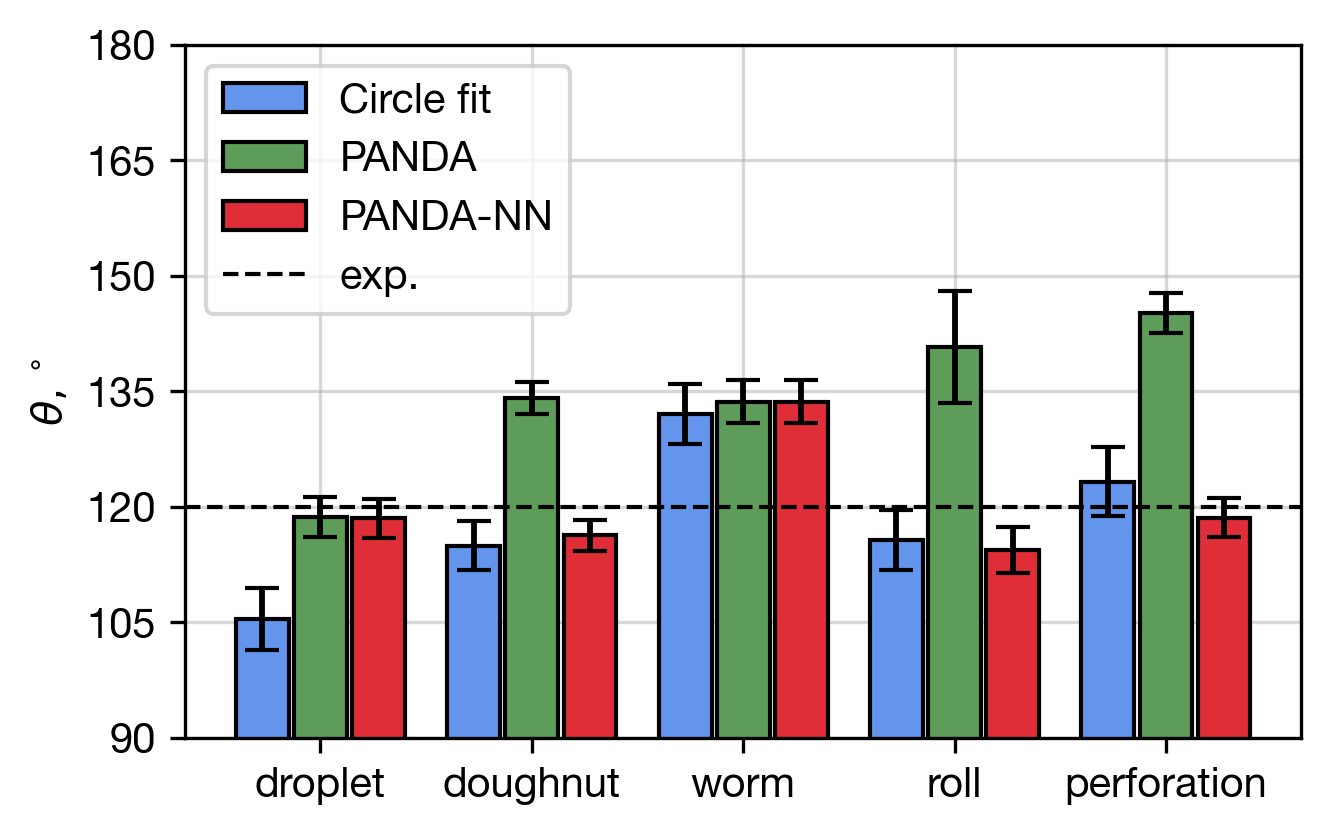

In [13]:
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

golden_ratio = (1 + np.sqrt(5)) / 2
# fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5), dpi=300)
width = 0.25

scale = 1.2
# Visualisation of density profile with different PANDA algorithm version
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), dpi=300)
# fig, ax = plt.subplots(figsize=(4*scale, 3*scale), dpi=300)
fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

ax.grid(True, alpha=0.5, zorder=1)

elinewidth = 1.4
spacing = 0.1
# Plot bars
ax.bar(x + width * (1 + spacing), values2, width, color='#DF2E38', edgecolor='black', fill=True, yerr=errors2,
       error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='PANDA-NN')
ax.bar(x, values1, width, color='#5D9C59', edgecolor='black', fill=True, yerr=errors1,
       error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='PANDA')
ax.bar(x - width * (1 + spacing), values3, width, color='#6495ED', edgecolor='black', fill=True, yerr=errors3,
       error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='Circle fit')
# Dashed reference line
ax.axhline(120, color='black', linestyle='dashed', linewidth=1, zorder=3, label='exp.')

# Formatting
ticks = np.arange(90, 181, 15)
ax.set_xticks(x)
ax.set_xticklabels(groups, fontproperties=helvetica_font)
ax.set_yticks(ticks)
ax.set_yticklabels([str(t) for t in ticks], fontproperties=helvetica_font)
ax.set_ylabel(r'$\theta, ^\circ$', fontproperties=helvetica_font)
# ax.set_ylabel('theta', loc='bottom')
# ax.yaxis.set_label_coords(-0.05, 1.02)
# ax.yaxis.set_major_locator(FixedLocator(ticks))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_ylim(ticks[0], ticks[-1])
ax.set_ylim(90, 180)
ax.legend(prop=helvetica_font, loc='upper left', reverse=True)

fig.savefig(f'../img/Article2_panda_nn/angles_compare.png', dpi=300, bbox_inches='tight')
plt.show()

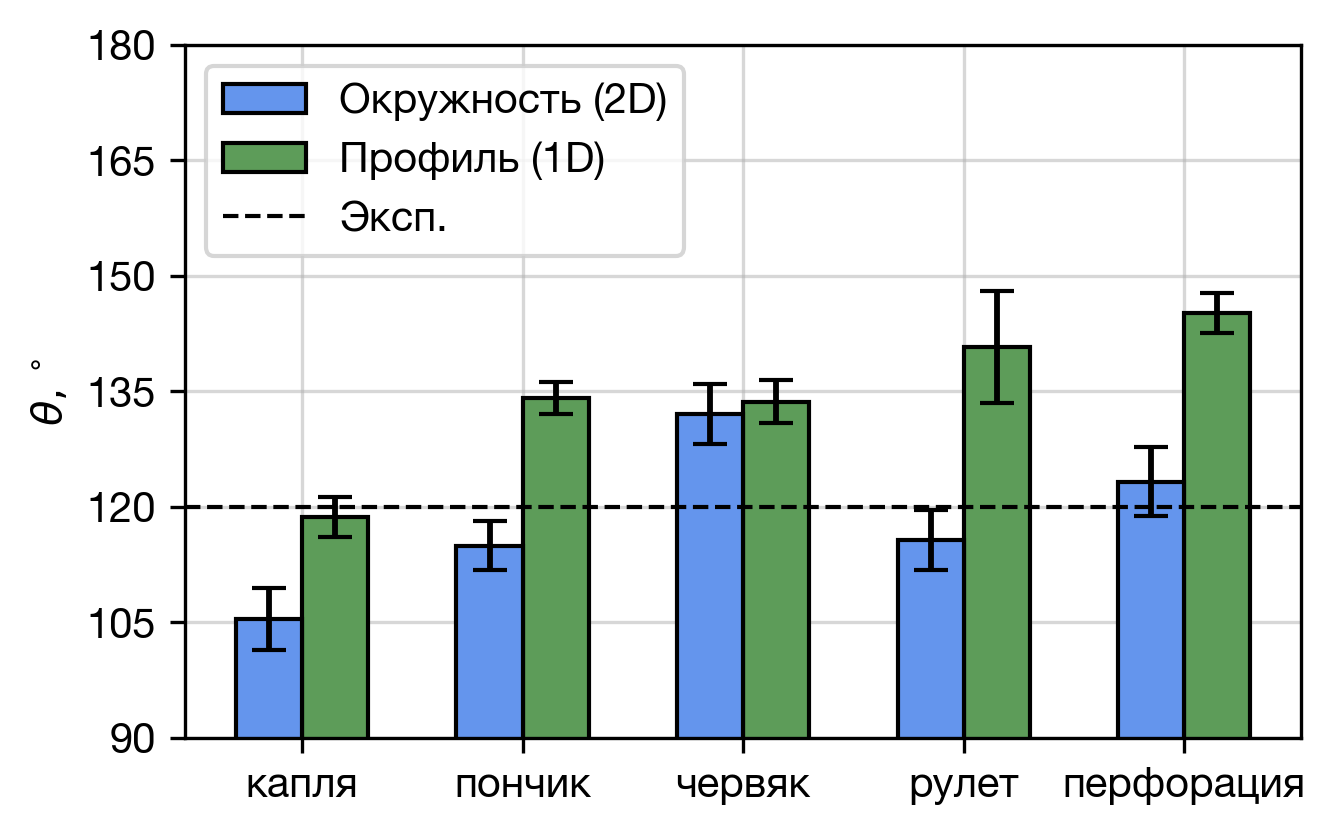

In [25]:
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

golden_ratio = (1 + np.sqrt(5)) / 2
# fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5), dpi=300)
width = 0.3

scale = 1.2
# Visualisation of density profile with different PANDA algorithm version
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), dpi=300)
# fig, ax = plt.subplots(figsize=(4*scale, 3*scale), dpi=300)
fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

ax.grid(True, alpha=0.5, zorder=1)

elinewidth = 1.4
spacing = 0
# Plot bars
# ax.bar(x - width / 2 - spacing / 2, values2, width, color='#DF2E38', edgecolor='black', fill=True, yerr=errors2,
    #    error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='PANDA-NN')
ax.bar(x + width / 2 + spacing / 2, values1, width, color='#5D9C59', edgecolor='black', fill=True, yerr=errors1,
       error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='Профиль (1D) ')
ax.bar(x - width / 2 - spacing / 2, values3, width, color='#6495ED', edgecolor='black', fill=True, yerr=errors3,
       error_kw={'elinewidth': elinewidth, 'capsize': 4}, zorder=2, label='Окружность (2D)')
# Dashed reference line
ax.axhline(120, color='black', linestyle='dashed', linewidth=1, zorder=3, label='Эксп.')

# Formatting
ticks = np.arange(90, 181, 15)
ax.set_xticks(x)
groups_rus = ['капля', 'пончик', 'червяк', 'рулет', 'перфорация']
ax.set_xticklabels(groups_rus, fontproperties=helvetica_font)
ax.set_yticks(ticks)
ax.set_yticklabels([str(t) for t in ticks], fontproperties=helvetica_font)
ax.set_ylabel(r'$\theta, ^\circ$', fontproperties=helvetica_font)
# ax.set_ylabel('theta', loc='bottom')
# ax.yaxis.set_label_coords(-0.05, 1.02)
# ax.yaxis.set_major_locator(FixedLocator(ticks))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_ylim(ticks[0], ticks[-1])
ax.set_ylim(90, 180)
ax.legend(prop=helvetica_font, loc='upper left', reverse=True)

fig.savefig(f'../img/Article2_panda_nn/angles_compare.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

golden_ratio = (1 + np.sqrt(5)) / 2
# fig, ax = plt.subplots(figsize=(5 * golden_ratio, 5), dpi=300)

scale = 2
# Visualisation of density profile with different PANDA algorithm version
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), dpi=300)
fig, ax = plt.subplots(figsize=(4*scale, 3*scale), dpi=300)
# fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

ax.grid(True, alpha=0.5, zorder=1)

# Plot bars
ax.bar(x - width/2, [i / 200 for i in ], width, color='#5D9C59', edgecolor='black', fill=True, zorder=2, label='PANDA')
ax.bar(x + width/2, [i / 200 for i in mean_losses_alpha], width, color='#DF2E38', edgecolor='black', fill=True, zorder=2, label='PANDA-NN')


# Formatting
# ticks = np.arange(0, 181, 30)
ax.set_xticks(x)
ax.set_xticklabels(groups, fontproperties=helvetica_font)
# ax.set_yticks(ticks)
# ax.set_yticklabels([str(t) for t in ticks], fontproperties=helvetica_font)
ax.set_ylabel('MAE', fontproperties=helvetica_font)
# ax.set_ylabel('theta', loc='bottom')
# ax.yaxis.set_label_coords(-0.05, 1.02)
# ax.yaxis.set_major_locator(FixedLocator(ticks))
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_ylim(ticks[0], ticks[-1])
# ax.set_ylim(0, 180)
ax.legend(prop=helvetica_font)

fig.savefig(f'../img/Article2_panda_nn/angles_compare_MAE.png', dpi=300, bbox_inches='tight')
plt.show()

SyntaxError: invalid syntax (1694394362.py, line 24)

In [16]:
mean_mae_theta

[0.00592971413851187,
 0.03319478939316221,
 0.017215086233611638,
 0.04744112059997926,
 0.06189737483098058]

In [19]:
[std / mean for std, mean in zip(std_mae_theta, mean_mae_theta)]

[0.16019907103504336,
 0.043384474216638075,
 0.044443863944167036,
 0.1904230918720377,
 0.03762758964789641]

In [15]:
result = list(zip(shapes, mean_mae_theta, mean_mae_alpha, mean_rmse_theta, mean_rmse_alpha))

print(
    tabulate(
        result,
        headers=["shape", "mae_theta", "mae_alpha", "rmse_theta", "rmse_alpha"],
        tablefmt="github",
        floatfmt=".3f",
    )
)

| shape       |   mae_theta |   mae_alpha |   rmse_theta |   rmse_alpha |
|-------------|-------------|-------------|--------------|--------------|
| droplet     |       0.006 |       0.006 |        0.015 |        0.014 |
| doughnut    |       0.033 |       0.020 |        0.074 |        0.042 |
| worm        |       0.017 |       0.017 |        0.038 |        0.038 |
| roll        |       0.047 |       0.027 |        0.098 |        0.056 |
| perforation |       0.062 |       0.037 |        0.139 |        0.082 |


In [9]:
print('Theta: {:.2f}'.format(np.sqrt(np.mean(np.array([(angle - 120)**2 for angle in mean_angles_theta])))))
print('Alpha: {:.2f}'.format(np.sqrt(np.mean(np.array([(angle - 120)**2 for angle in mean_angles_alpha])))))

Theta: 17.08
Alpha: 6.95


In [10]:
6.95 / 17.08

0.4069086651053865

In [23]:
rmse_angles_theta
rmse_angles_alpha

result = list(zip(shapes, rmse_angles_theta, rmse_angles_alpha))

print(
    tabulate(
        result,
        headers=["shape", "rmse_angles_theta", "rmse_angles_alpha"],
        tablefmt="github",
        floatfmt=".2f",
    )
)

| shape       |   rmse_angles_theta |   rmse_angles_alpha |
|-------------|---------------------|---------------------|
| droplet     |                2.93 |                2.95 |
| doughnut    |                6.40 |                6.72 |
| worm        |               14.22 |               14.22 |
| roll        |               21.98 |                6.34 |
| perforation |               25.31 |                2.88 |


---

In [23]:
shape = 'roll'

In [24]:
folder = f'{root}/PANDA_exp/panda_nn/calcite_decane_water_{shape}'

# Configuration parameters of the system
with open(osp.join(folder, 'config.json'), 'r') as f:
    config = json.load(f)

trajectory_file = osp.join(folder, 'cal_dec_tip4p.xtc')
topology_file = osp.join(folder, 'cal_dec_tip4p.gro')
residue = 'DECAN'
H = config['H']
l = (12.003 + 11.244) / 2 / H
phi = config['phi']
rho_bulk = 3.0896 * 10
interface_type = config['interface_type']
sl = 200
timestep = 2
units = "ps"
block_length = 2_000
chunk_length = 1_000
begin_time = 0
time = config['nsteps'] * timestep // 1000

axises = np.load(osp.join(folder, 'axises.npy'))
denses = np.load(osp.join(folder, 'denses.npy'))

# Averaging axises and denses arrays by blocks
blocks_num = axises.shape[0] // block_length

mean_axises = np.zeros((blocks_num, axises.shape[1]))
mean_denses = np.zeros((blocks_num, denses.shape[1]))
for i in range(blocks_num):
    mean_axises[i, :] = np.mean(axises[(i * block_length):((i+1) * block_length), :], axis=0)
    mean_denses[i, :] = np.mean(denses[(i * block_length):((i + 1) *block_length), :], axis=0)

# Calculating contact angle using PANDA algorithm
angles_theta = np.zeros(blocks_num)
angles_alpha = np.zeros(blocks_num)
delta_alpha = np.zeros(blocks_num)

normalized_axises = np.zeros((blocks_num, axises.shape[1]))
normalized_denses = np.zeros((blocks_num, denses.shape[1]))
for i in range(blocks_num):
    axis_i, dens_i, result_theta = profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type=interface_type,
        samples=10,
        extention='theta',
        display=False
    )

    _, _, result_alpha = profile_approx_from_array(
        mean_denses[i, :],
        mean_axises[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type=interface_type,
        samples=10,
        extention='alpha',
        display=False
    )

    normalized_axises[i, :] = axis_i
    normalized_denses[i, :] = dens_i

    angles_theta[i] = result_theta['theta']
    angles_alpha[i] = result_alpha['theta']
    delta_alpha[i] = result_alpha['delta']

# Averagin angle for different interface
begin_alpha = 2
mean_angle = np.mean(np.rad2deg(angles_alpha)[begin_alpha:])
std_angle = np.std(np.rad2deg(angles_alpha)[begin_alpha:])

begin_theta = 2
mean_angle = np.mean(np.rad2deg(angles_theta)[begin_theta:])
std_angle = np.std(np.rad2deg(angles_theta)[begin_theta:])

In [16]:
def findvalue(seq, val, rtol=0.05):    # value that works for your example
    return np.where(np.isclose(seq, val, rtol=rtol))[0]

offset = findvalue(normalized_axises[i, :], 0.5, 0.01)[0]

NameError: name 'src' is not defined

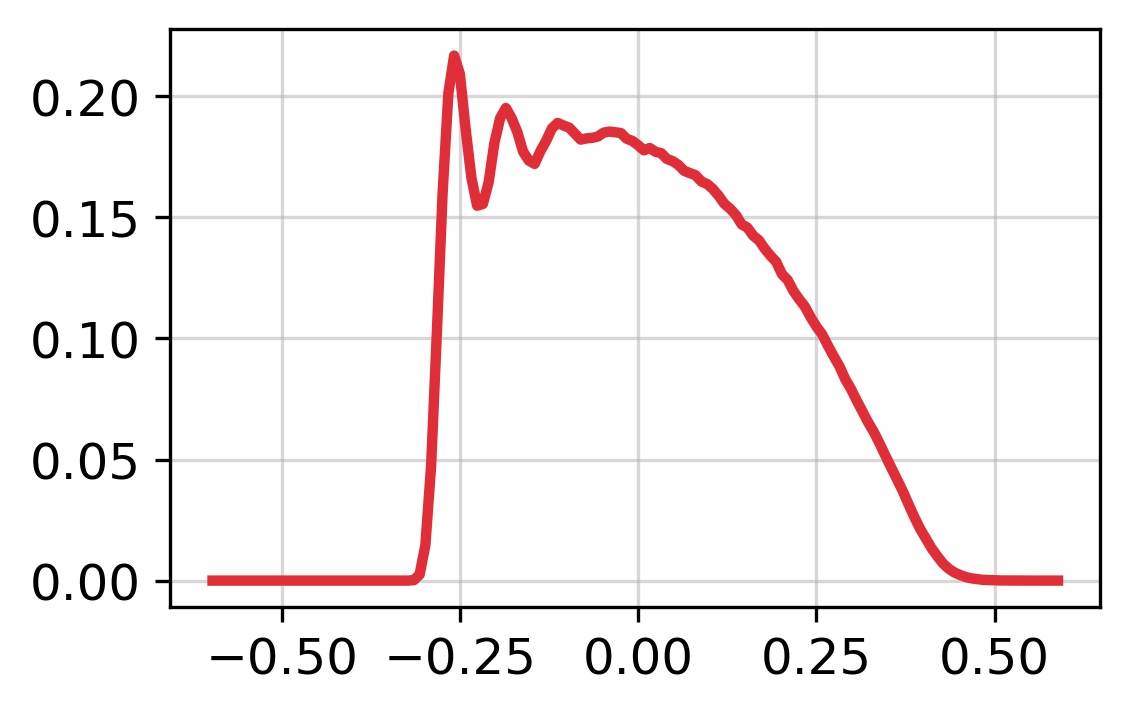

In [17]:
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

scale = 1.0
# Visualisation of density profile with different PANDA algorithm version
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), dpi=300)
# fig, ax = plt.subplots(figsize=(4*scale, 3*scale), dpi=300)
fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

i = -1

def findvalue(seq, val, rtol=0.05):    # value that works for your example
    return np.where(np.isclose(seq, val, rtol=rtol))[0]

offset = len(normalized_axises[i, :])- findvalue(normalized_axises[i, :], 0.6, 0.01)[0]

ax.grid(alpha=0.5)
ax.plot(
    normalized_axises[i, offset:-offset], normalized_denses[i, offset:-offset],
    label='decane',
    color='#DF2E38',
    linewidth=2.5
)

rho_alpha = getattr(src.utils_py.interface, f"rho_{interface_type}_alpha")

ax.plot(
    normalized_axises[i, offset:-offset], rho_alpha(normalized_axises[i, offset:-offset], l, phi, angles_alpha[i], delta_alpha[i]),
    # label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_alpha[i])),
    label=r'PANDA-NN ($\theta$ = {:.1f}$^\circ$)'.format(np.rad2deg(angles_alpha[i])),
    color='#000000',
    linewidth=3,
    linestyle='dashed'
)


xticks = np.round(np.arange(-0.6, 0.61, 0.3), 1)
ax.xaxis.set_major_locator(FixedLocator(xticks))
ax.set_xticks(xticks, labels=xticks, fontproperties=helvetica_font, fontsize=12)
ax.set_xlabel('z', fontproperties=helvetica_font, fontsize=14)

yticks = np.round(np.arange(0, 1.01, 0.2), 1)
ax.set_yticks(yticks, labels=yticks, fontproperties=helvetica_font, fontsize=12)
ax.set_ylabel(r'$\rho / \rho_{bulk}$', fontproperties=helvetica_font, fontsize=14)

ax.legend(loc='best', prop=helvetica_font, fontsize=12)

# plt.tight_layout()
# fig.set_size_inches(4*scale, 2.5*scale)
fig.savefig(f'../img/Article2_panda_nn/{shape}_prof_alpha.png', dpi=300, bbox_inches='tight')
plt.show()

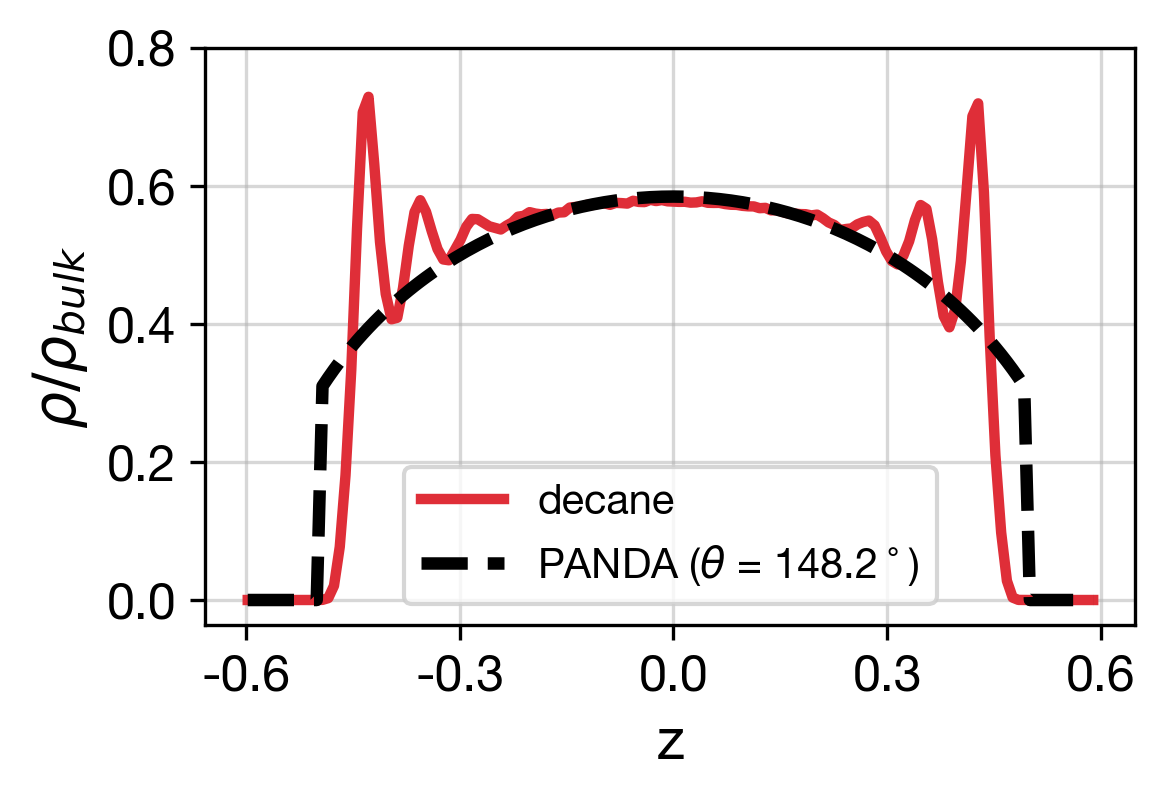

In [27]:
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

scale = 1.0
# Visualisation of density profile with different PANDA algorithm version
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), dpi=300)
# fig, ax = plt.subplots(figsize=(4*scale, 3*scale), dpi=300)
fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

i = -1

def findvalue(seq, val, rtol=0.05):    # value that works for your example
    return np.where(np.isclose(seq, val, rtol=rtol))[0]

offset = len(normalized_axises[i, :])- findvalue(normalized_axises[i, :], 0.6, 0.01)[0]

ax.grid(alpha=0.5)
ax.plot(
    normalized_axises[i, offset:-offset], normalized_denses[i, offset:-offset],
    label='decane',
    color='#DF2E38',
    linewidth=2.5
)

rho_theta = getattr(panda.interface, f"rho_{interface_type}_theta")

ax.plot(
    normalized_axises[i, offset:-offset], rho_theta(normalized_axises[i, offset:-offset], l, phi, angles_theta[i]),
    # label=r'approximation with $\theta$ = {:.1f}$^\circ$'.format(np.rad2deg(angles_alpha[i])),
    label=r'PANDA ($\theta$ = {:.1f}$^\circ$)'.format(np.rad2deg(angles_theta[i])),
    color='#000000',
    linewidth=3,
    linestyle='dashed'
)


xticks = np.round(np.arange(-0.6, 0.61, 0.3), 1)
ax.xaxis.set_major_locator(FixedLocator(xticks))
ax.set_xticks(xticks, labels=xticks, fontproperties=helvetica_font, fontsize=12)
ax.set_xlabel('z', fontproperties=helvetica_font, fontsize=14)

yticks = np.round(np.arange(0, 0.81, 0.2), 1) # roll
# yticks = np.round(np.arange(0, 0.31, 0.1), 2)
ax.set_yticks(yticks, labels=yticks, fontproperties=helvetica_font, fontsize=12)
ax.set_ylabel(r'$\rho / \rho_{bulk}$', fontproperties=helvetica_font, fontsize=14)

ax.legend(loc='best', prop=helvetica_font, fontsize=12)

# plt.tight_layout()
fig.savefig(f'../img/Article2_panda_nn/{shape}_prof_theta.png', dpi=300, bbox_inches='tight')
plt.show()

---

/tmp/ipykernel_21513/2796654408.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='gray', linewidth=0.5))
/tmp/ipykernel_21513/2796654408.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


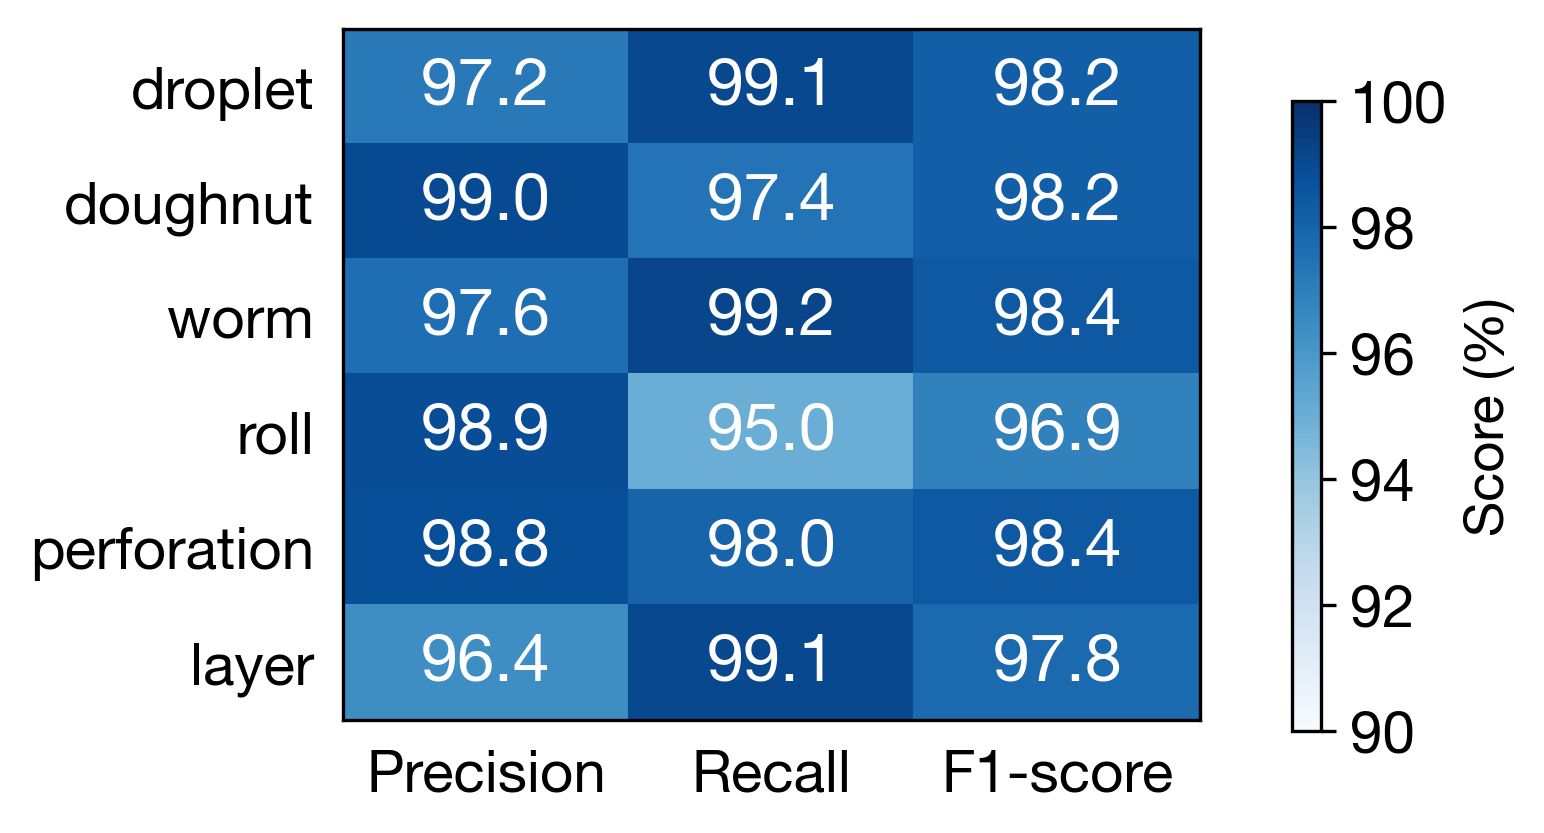

In [36]:
# Update global rcParams to match your style
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

# Your data
classes = ["droplet", "doughnut", "worm", "roll", "perforation", "layer"]
metrics = ["Precision", "Recall", "F1-score"]
values = np.array([
    [97.2, 99.1, 98.2],
    [99.0, 97.4, 98.2],
    [97.6, 99.2, 98.4],
    [98.9, 95.0, 96.9],
    [98.8, 98.0, 98.4],
    [96.4, 99.1, 97.8],
])

# Figure config
scale = 1.2
fig, ax = plt.subplots(figsize=(4*scale, 2.5*scale), dpi=300)

# Define colormap and value normalization
# cmap = plt.cm.YlGnBu
# cmap = plt.cm.viridis
cmap = plt.cm.Blues
vmin, vmax = 90, 100
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Draw heatmap
for i in range(len(classes)):
    for j in range(len(metrics)):
        val = values[i, j]
        color = cmap(norm(val))
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='gray', linewidth=0.5))
        # text_color = 'white' if val < vmin else 'black'
        text_color = 'white'
        ax.text(j + 0.5, i + 0.5, f"{val:.1f}", ha='center', va='center',
                fontproperties=helvetica_font, fontsize=16, color=text_color)

# Set ticks and labels
ax.set_xticks(np.arange(len(metrics)) + 0.5)
ax.set_xticklabels(metrics, fontproperties=helvetica_font, fontsize=14)
ax.set_yticks(np.arange(len(classes)) + 0.5)
ax.set_yticklabels(classes, fontproperties=helvetica_font, fontsize=14)
ax.set_xlim(0, len(metrics))
ax.set_ylim(0, len(classes))
ax.invert_yaxis()  # So first class is on top
ax.tick_params(left=False, bottom=False)
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# Title
# ax.set_title("Classification Metrics per Interface Type", fontproperties=helvetica_font, fontsize=16, weight='bold')

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cb.set_label('Score (%)', fontproperties=helvetica_font, fontsize=13)
cb.ax.yaxis.set_tick_params(labelsize=14)
for label in cb.ax.get_yticklabels():
    label.set_fontproperties(helvetica_font)
    label.set_fontsize(14)

# Save and show
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
fig.set_size_inches(4*scale, 2.5*scale)
fig.savefig('../img/Article2_panda_nn/classification_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_21513/1167782208.py:42: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='gray', linewidth=0.5))
/tmp/ipykernel_21513/1167782208.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


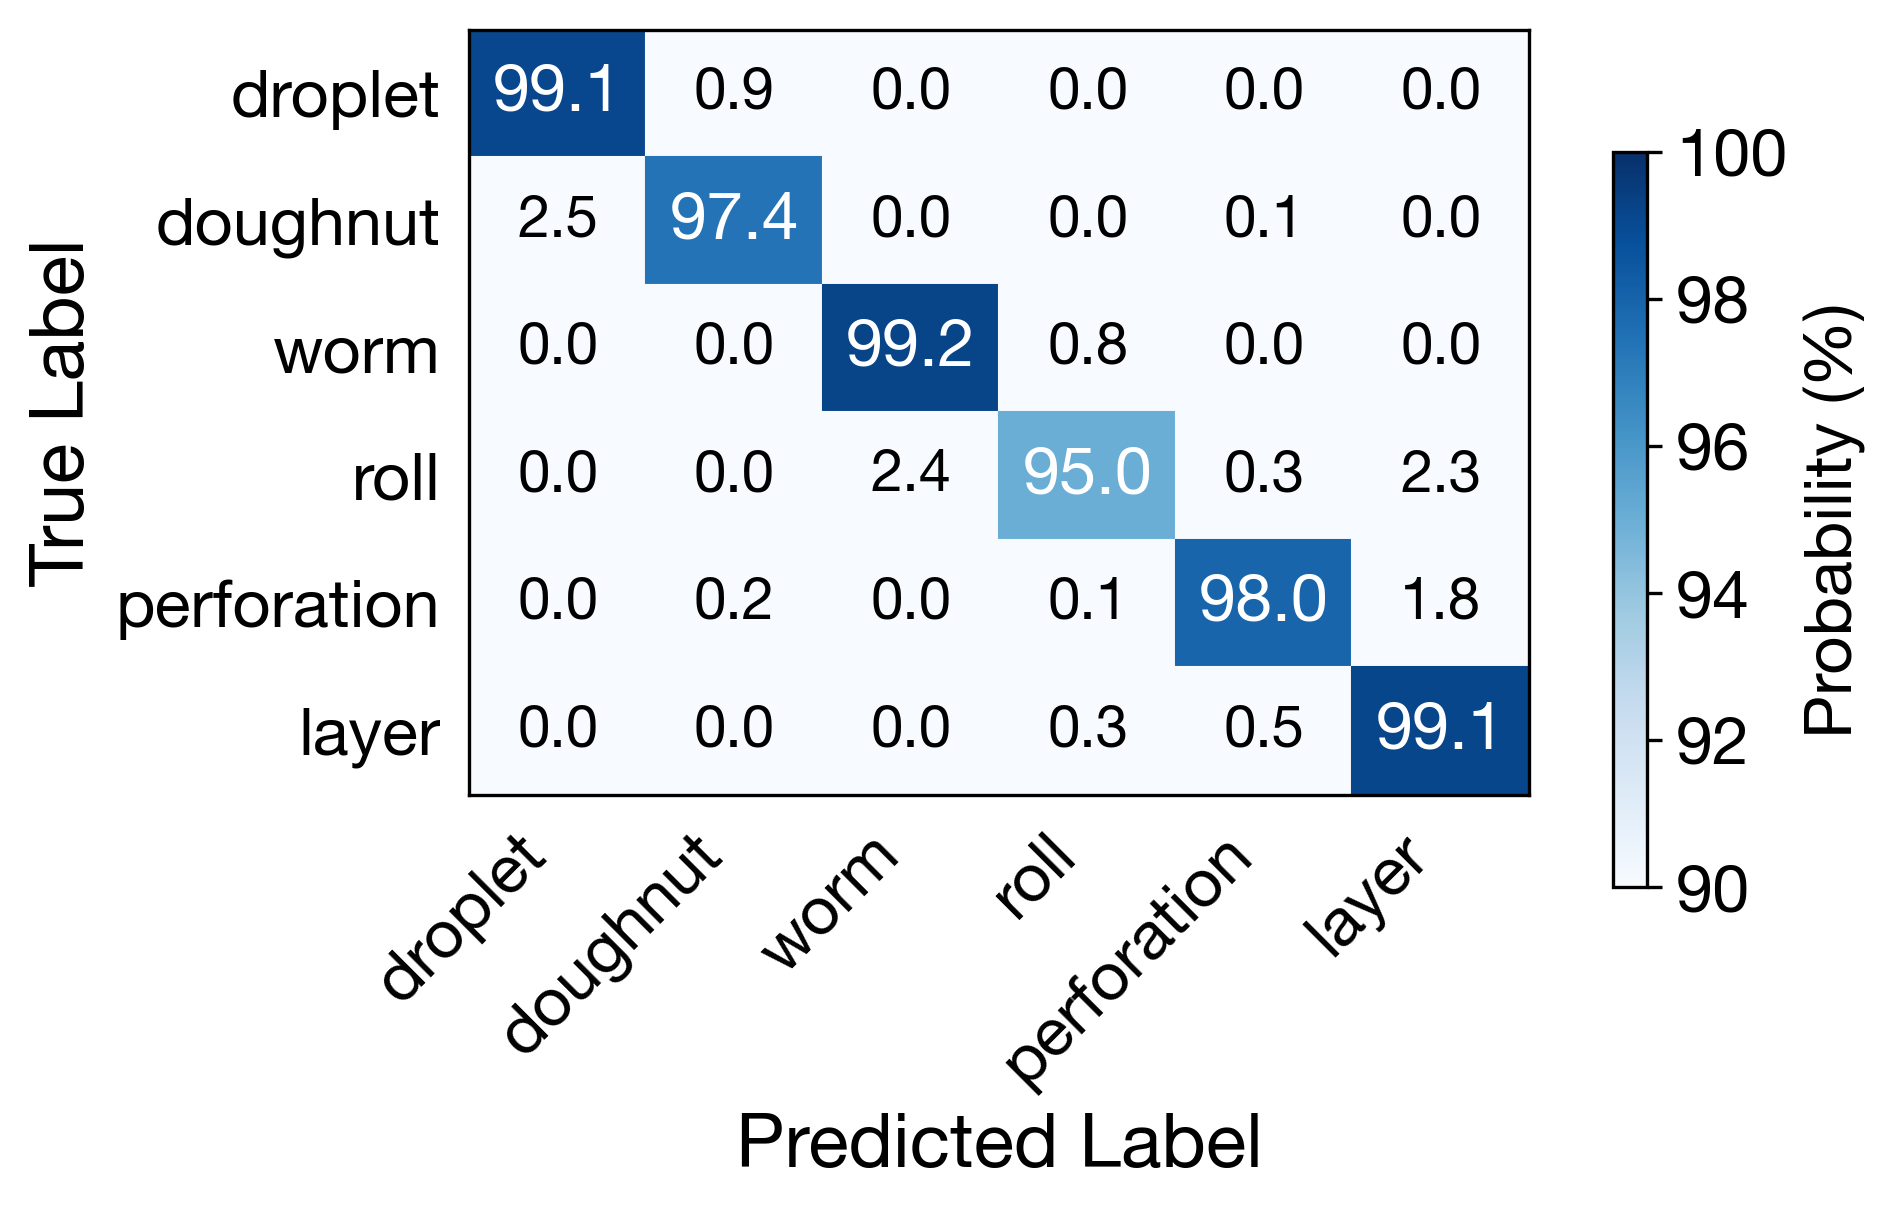

In [ ]:
# Update global rcParams to match style
mpl.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
    "lines.markersize": 6
})

# Your confusion matrix data
confusion_matrix = np.array([
    [9.91164241e-01, 8.83575884e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [2.50812819e-02, 9.73989782e-01, 0.00000000e+00, 0.00000000e+00, 9.28936368e-04, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 9.92292871e-01, 7.70712909e-03, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 2.42057489e-02, 9.50075643e-01, 3.02571861e-03, 2.26928896e-02],
    [0.00000000e+00, 1.52439024e-03, 0.00000000e+00, 1.01626016e-03, 9.79674797e-01, 1.77845528e-02],
    [0.00000000e+00, 3.89711613e-04, 0.00000000e+00, 2.72798129e-03, 5.45596259e-03, 9.91426345e-01]
]) * 100

# Class names (same as in your example)
classes = ["droplet", "doughnut", "worm", "roll", "perforation", "layer"]

# Figure config
scale = 1.4
fig, ax = plt.subplots(figsize=(5*scale, 4.5*scale), dpi=300)

# Define colormap and value normalization
# cmap = plt.cm.YlGnBu
# cmap = plt.cm.viridis
cmap = plt.cm.Blues
vmin, vmax = 90, 100  # Normalized values are between 0 and 1
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# Draw heatmap
for i in range(len(classes)):
    for j in range(len(classes)):
        val = confusion_matrix[i, j]
        color = cmap(norm(val))
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='gray', linewidth=0.5))

        # Display text in percentage format with 1 decimal place
        # White for darker cells, black for lighter cells
        text_color = 'white' if val > 50 else 'black'
        fontsize = 14 if val > 50 else 12
        # text_color = 'white'
        ax.text(j + 0.5, i + 0.5, f"{val:.1f}", ha='center', va='center',
                fontproperties=helvetica_font, fontsize=fontsize, color=text_color)

# Set ticks and labels
ax.set_xticks(np.arange(len(classes)) + 0.5)
ax.set_xticklabels(classes, fontproperties=helvetica_font, rotation=45, ha='right', fontsize=14)
ax.set_yticks(np.arange(len(classes)) + 0.5)
ax.set_yticklabels(classes, fontproperties=helvetica_font, fontsize=14)
ax.set_xlim(0, len(classes))
ax.set_ylim(0, len(classes))
ax.invert_yaxis()  # So first class is on top

# Remove the ticks, keep only the labels
ax.tick_params(left=False, bottom=False)
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# Add axis labels
ax.set_xlabel('Predicted Label', fontproperties=helvetica_font, fontsize=16)
ax.set_ylabel('True Label', fontproperties=helvetica_font, fontsize=16)
# ax.set_title("Confusion Matrix", fontproperties=helvetica_font, fontsize=16, weight='bold')

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm)
cb.set_label('Probability (%)', fontproperties=helvetica_font, fontsize=14)
cb.ax.yaxis.set_tick_params(labelsize=14)
for label in cb.ax.get_yticklabels():
    label.set_fontproperties(helvetica_font)
    label.set_fontsize(14)

# Save and show
plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
fig.set_size_inches(4*scale, 2.5*scale)
fig.savefig('../img/Article2_panda_nn/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()